In [2]:
import os
import importlib.util
import torch.distributed as dist
import torch
from data.builder import build_dataset
from models.detectors.zid_rcnn import ZidRCNN
from scripts import dist_util
from models.utils.data_container import collate
from functools import partial
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
from models.utils.det_utils import bbox2result, bbox2roi

In [4]:
def build_detector(model_cfg):
    model_cfg_ = model_cfg.copy()

    model_type = model_cfg_.pop('type') 
    assert model_type == 'ZidRCNN', f'{model_type} is not implemented yet.'
    return ZidRCNN(**model_cfg_)
    
def get_config_from_file(filename, mode):
    spec = importlib.util.spec_from_file_location(mode, filename)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)

    # Create a dictionary from module attributes
    config_dict = {key: getattr(module, key) for key in dir(module) if not key.startswith('__')}
    return config_dict

In [5]:
def test_batch_processing(batch):
    batch['obj_id'] = batch['id'][0]
    batch.pop('id')
    for k, v in batch.items():
        if k == 'img_metas':
            batch[k] = batch[k][0].data
        if k == 'img':
            batch[k] = [batch[k][0].data[0].to(device, non_blocking=True)]
        
        elif k in ['rgb', 'mask', 'traj']:
            batch[k] = batch[k].data.to(device, non_blocking=True)
    return batch

In [6]:
cfg = get_config_from_file('configs/test_conf.py', 'detection')
cfg.get('model')['train_cfg'] = None

In [7]:
dataset = build_dataset(cfg.get('data')['test'])

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [8]:
device = torch.device('cuda:4')

In [9]:
model = build_detector(cfg.get('model'))
# shared_drive_cv/FewshotObjectDetection/outputs/VoxDet_p1/iter_19201.pth
model_path = '/home/minhnh/project_drive/CV/FewshotObjectDetection/VoxDet-simplified/results/ckpt/model_ep10_058000.pt'
model.load_state_dict(
    torch.load(model_path, map_location="cpu")
)
model.CLASSES = dataset.CLASSES
device = torch.device('cuda:4')
model.to(device)
model.eval()
print('Loaded model')

load model from: torchvision://resnet50
LOAD Backbone ResNET50 torchvision://resnet50
Loaded model


In [10]:
data = torch.utils.data.DataLoader(dataset,
                                    batch_size=1,
                                    num_workers=2,
                                    shuffle=False,
                                    pin_memory=False,
                                    collate_fn=partial(collate, samples_per_gpu=1))

In [20]:
P1_base = '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/'
obj_ids = os.listdir(P1_base)
support_data = dict(rgb=[], mask=[])
for obj_id in tqdm(obj_ids):

    tar_path = os.path.join(P1_base, '{}'.format(obj_id))
    # try:
    #     os.remove(os.path.join(tar_path, 'info.npz'))
    # except:
    #     pass
    
    try:
        p1_data = np.load(os.path.join(tar_path, 'info224.npz'))
        M = p1_data['rgb'].shape[0]
        support_data['rgb'].append(torch.from_numpy(p1_data['rgb'].astype(np.float32))[range(0, M, 4), :])
        support_data['mask'].append(torch.from_numpy(p1_data['mask'].astype(np.float32))[range(0, M, 4), :])
        print(len(support_data['mask']))
    except:
        continue
support_data['rgb'] = torch.stack(support_data['rgb']).to(device)
support_data['mask'] = torch.stack(support_data['mask']).to(device)

  0%|          | 0/24 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

In [18]:
p1_data['mask'][range(0, M, 4), :].shape

(40, 3, 224, 224)

In [12]:
num_supports = support_data['rgb'].shape[0]

In [12]:
results = []
torch.multiprocessing.set_sharing_strategy('file_system')
ind = 0
for batch in tqdm(data):
    ind += 1
    if ind < 3:
        continue
    batch = test_batch_processing(batch)
    
    with torch.no_grad():
        img = batch['img'][0]
        support_rgb = support_data['rgb']
        support_mask = support_data['mask']
        supports = [dict(rgb=support_rgb, mask=support_mask)]
        x = model.extract_feat(img)
        supp_feats = model.extract_supp_feat(supports)
        proposals = model.rpn_head.simple_test_rpn(x, batch['img_metas'][0])
        
        rpn_score = torch.cat([p[:, -1:] for p in proposals], 0)
        # topk
        ind = torch.topk(rpn_score, 500, dim=0)[1].squeeze()
        origin_proposals = proposals[0]
        new_proposals = origin_proposals[ind]
        proposals = [new_proposals]
        rpn_score = rpn_score[ind]
        rois = bbox2roi(proposals)
        
        B = 1
        supp_roi_feats = []
        supp_roi_feats_contrastive = []
        # supp_labels = []
        for i in range(B):
            supp_rois = bbox2roi([b.unsqueeze(0) for b in supp_feats[i]['support_bbox']])
            # print("P1 ROI", p1_rois.shape)
            support_x = supp_feats[i]['support_feat']
            support_roi_feat = model.roi_head.bbox_roi_extractor(
                support_x, supp_rois)
            num_gts = num_supports
            support_roi_feat = support_roi_feat.reshape(num_gts, -1, support_roi_feat.shape[1], support_roi_feat.shape[2], support_roi_feat.shape[3])
            num_views = support_roi_feat.shape[1]
            support_roi_feat_agg = torch.max(support_roi_feat, dim=1)[0]
            supp_roi_feats.append(support_roi_feat_agg)
            supp_roi_feats_contrastive.append(torch.cat([support_roi_feat, support_roi_feat_agg.unsqueeze(1)], dim=1).flatten(0,1))
            # supp_labels.append(gt_categories[i].repeat(num_views + 1, 1).transpose(1, 0).flatten())
        supp_roi_feats_contrastive = torch.cat(supp_roi_feats_contrastive)
        # supp_labels = torch.cat(supp_labels)
        
        bbox_feats = model.roi_head.bbox_roi_extractor(
            x[:model.roi_head.bbox_roi_extractor.num_inputs], rois)
        if model.roi_head.with_shared_head:
            bbox_feats = model.roi_head.shared_head(bbox_feats)
        # test will pre save p1
        # sample = dict(bbox_feats=bbox_feats, support=support, rois=rois, gt_bboxes=gt_bboxes)
        
        roi_feats = model.roi_head.roi_feat_extract(bbox_feats)
        for i in range(B):
            supp_roi_feats[i] = model.roi_head.roi_feat_extract(supp_roi_feats[i])

    break   
        # output = model(**batch, return_loss=False, rescale=True)
    # results.extend(output)
    # break

  0%|          | 2/4125 [00:02<1:26:02,  1.25s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 10.05 GiB. GPU 4 has a total capacty of 79.15 GiB of which 4.16 GiB is free. Process 3980000 has 1.33 GiB memory in use. Process 2566079 has 58.23 GiB memory in use. Including non-PyTorch memory, this process has 15.15 GiB memory in use. Of the allocated memory 14.47 GiB is allocated by PyTorch, and 197.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [133]:
bbox_feats.shape

torch.Size([500, 256, 7, 7])

In [134]:
x[0].shape

torch.Size([1, 256, 200, 272])

In [135]:
roi_feats.shape

torch.Size([500, 1024])

In [136]:
sim = torch.matmul(roi_feats, supp_roi_feats[0].T)

In [137]:
proposals[0].shape

torch.Size([500, 5])

In [138]:
torch.max(sim)

tensor(0.2420, device='cuda:4')

In [139]:
rois[torch.argmax(sim)]

tensor([  0.0000, 426.9800, 406.4941, 570.5029, 577.2444], device='cuda:4')

In [125]:
sim[torch.where(sim > 0.5)[0]]

tensor([], device='cuda:4', size=(0, 1))

In [141]:
temperature = 0.2
similarity = torch.div(
    sim, temperature)
# for numerical stability
# sim_row_max, _ = torch.max(similarity, dim=1, keepdim=True)
# similarity = similarity - sim_row_max.detach()

# mask out self-contrastive
logits_mask = torch.ones_like(similarity)
logits_mask.fill_diagonal_(0)

exp_sim = torch.exp(similarity) * logits_mask
log_prob = similarity - torch.log(exp_sim.sum(dim=1, keepdim=True))

# per_label_log_prob = (log_prob * logits_mask * label_mask)

In [148]:
exp_sim.shape

torch.Size([500, 1])

In [146]:
torch.exp(similarity) / exp_sim.sum(dim=1, keepdim=True)

tensor([[inf],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
     

In [144]:
log_prob.min()

tensor(-1.1921e-07, device='cuda:4')

In [126]:
rois[torch.where(sim > 0.5)[0]]

tensor([], device='cuda:4', size=(0, 5))

In [127]:
proposals[0][torch.where(sim > 0.5)[0]]

tensor([], device='cuda:4', size=(0, 5))

In [115]:
rois[297]

tensor([  0.0000, 574.8376, 558.4380, 713.0351, 736.8537], device='cuda:4')

In [116]:
rois.shape

torch.Size([2000, 5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


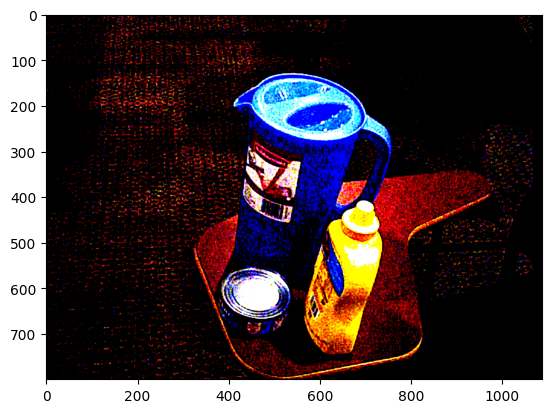

In [128]:
plt.imshow(batch['img'][0][0].permute(1,2,0).cpu())

In [129]:
batch

{'img_metas': [[{'filename': '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test/000052/rgb/000001.png',
    'ori_filename': '000052/rgb/000001.png',
    'ori_shape': (480, 640, 3),
    'img_shape': (800, 1067, 3),
    'pad_shape': (800, 1088, 3),
    'scale_factor': array([1.6671875, 1.6666666, 1.6671875, 1.6666666], dtype=float32),
    'flip': False,
    'flip_direction': None,
    'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
     'std': array([58.395, 57.12 , 57.375], dtype=float32),
     'to_rgb': True}}]],
 'img': [tensor([[[[-0.1143, -0.2342, -0.3883,  ...,  0.0000,  0.0000,  0.0000],
            [-0.1828, -0.1999, -0.2342,  ...,  0.0000,  0.0000,  0.0000],
            [-0.2684, -0.1657,  0.0056,  ...,  0.0000,  0.0000,  0.0000],
            ...,
            [-0.4568, -0.4054, -0.3369,  ...,  0.0000,  0.0000,  0.0000],
            [-0.5253, -0.5082, -0.4568,  ...,  0.0000,  0.0000,  0.0000],
            [-0.5767, -0.5596, -0.5424,  

In [ ]:
batch['

In [26]:
from PIL import Image
import numpy as np
def read_image(filepath):
    # Open the image file
    img = Image.open(filepath)
    # Convert the image to a Numpy array
    img_array = np.array(img)
    # Display the array
    return img_array

In [130]:
img_id = 1
obj_id = 11
img_path = '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test/000052/rgb/{:06d}.png'.format(img_id)
obj_path = '/home/minhnh/project_drive/CV/FewshotObjectDetection/data/ycbv/test_video/obj_{:06d}/rgb/000000.jpg'.format(obj_id)

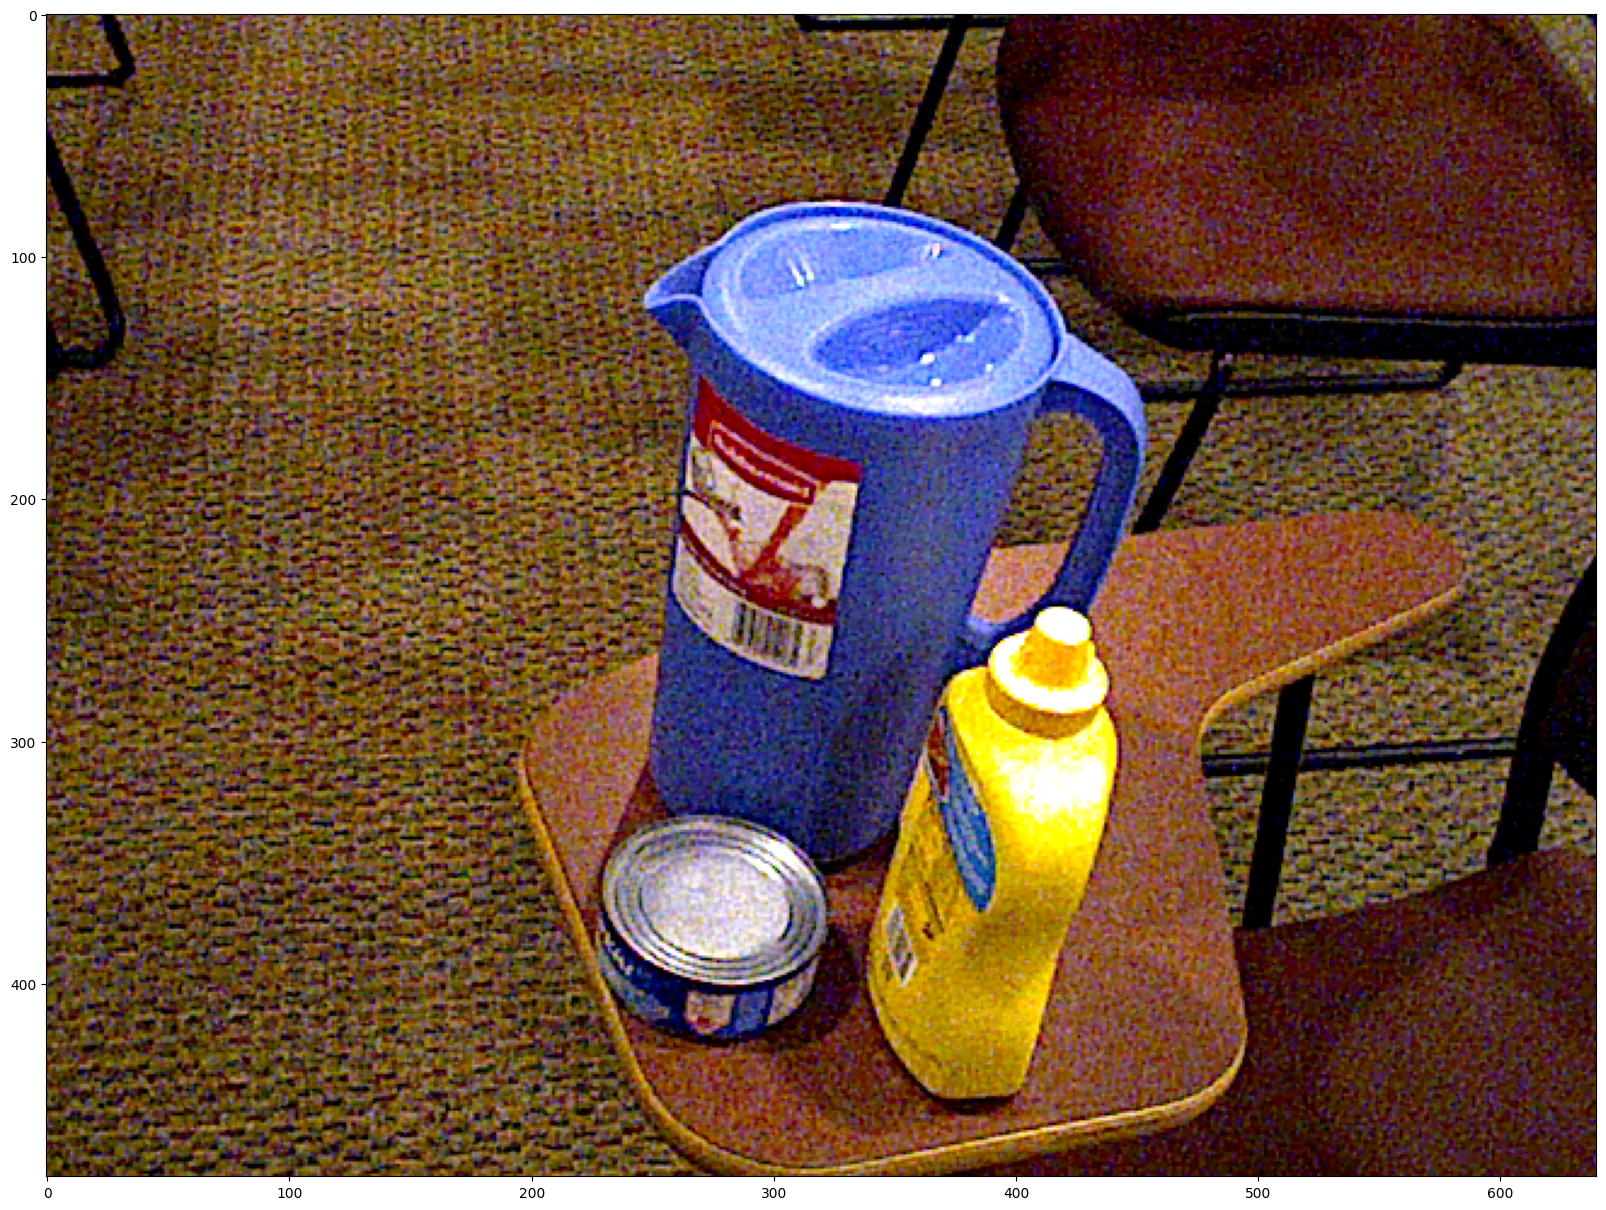

In [87]:
plt.figure(figsize=(20,30))
plt.imshow(read_image(img_path))

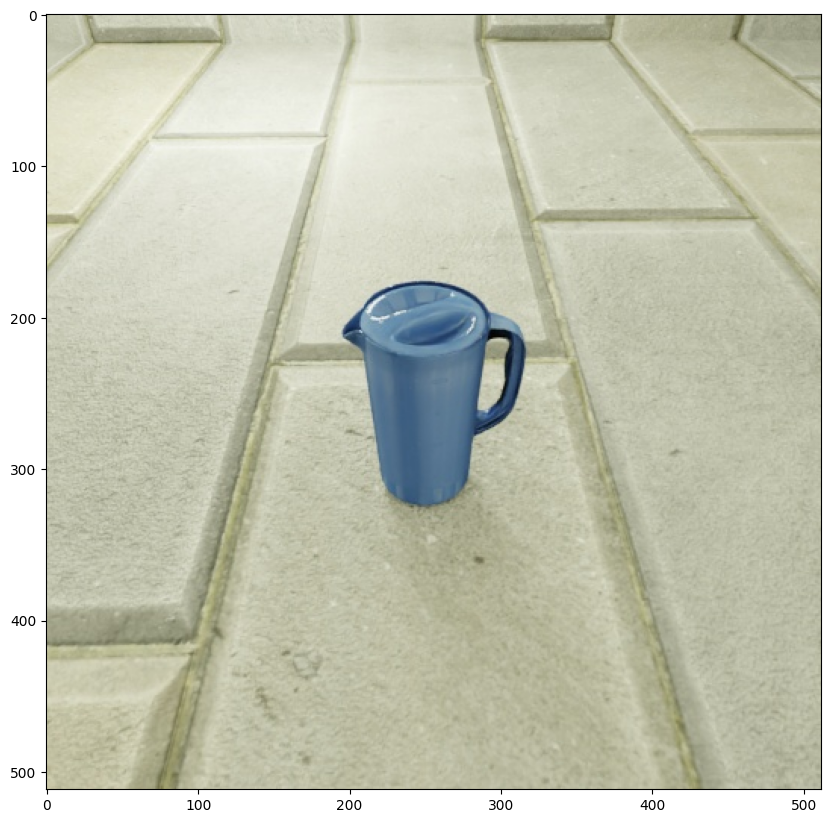

In [131]:
plt.figure(figsize=(10,15))
plt.imshow(read_image(obj_path))

In [ ]:
dataset.evaluate(results, jsonfile_prefix='results')